# Table of Contents
## 0. [Imports, data loading and initial checking](#DL)
## 1. [Features properties](#FP)
## 2. [Features enginering](#FE)
## 3. [Model hipothesis and discussion](#MH)
## 4. [Model building](#MB)
## 5. [Model selection](#MS)
## 6. [Conclussions](#C)
## 7. [Submission](#S)

In [13]:
import os
import re
import sys 
sys.path.insert(0, '../src/visualization/') # add the path which contains visualize
sys.path.insert(0, '../src/data/') # add the path which containing visualize
sys.path.insert(0, '../src/features/') # add the path which contains visualize

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualize as vsl  # own visualize.py file containing every visualization scripts
import fill_nulls as fln  # own fill_nulls.py file containing scripts to fill nan
import build_features as bf  # own build_features.py containing the script to generate features dataset 
from titanic_submission import submit_result  # own titanic_submission.py script to automatize submissions

from scipy.stats import kstest, kurtosis, shapiro, skew, boxcox
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [9,6]

# 0. Imports, data loading and initial checking <a class="anchor" id="DL"></a>

In [3]:
train_data = pd.read_csv('../data/raw/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that Age, Embarked and Cabin contain null values, so, we will keep it in mind (in order to fill them) if we consider that some of these features is relevant after the properties overview.

# 1. Features properties <a class="anchor" id="FP"></a>

In this section we are going to study the features properties in order to two main aspects:

1. Marginal Distribution to know how a feature acts marginally 

2. Joint distribution with Survived to know which features are significantly related with the survivors

The methodology is basicly take an overview with a pie chart (in the case of cathegorical features) or an histogram (in the case of numerical values), then we will plot the joint distribution with a stacked bars diagram (in the case of cathegorical features) or an histogram hued by survivor (in the case of numerical features) and in the case of cathegorical features we will perform a chi square test to check if the features are dependent (which does not means direct causality or correlation, just (in)dependance).

(The correlation between cathegorical features has to be studied carefully and it will be developed carefully in a future notebook)

## 1.1 PassengerId

This feature seems to be a unique identifier for every passenger, but we do not need it because it matches with our dataframe indexes. It will be removed.

In [5]:
train_data.drop('PassengerId', axis=1, inplace=True)

## 1.2 Pclass

### MARGINAL DISTRIBUTION

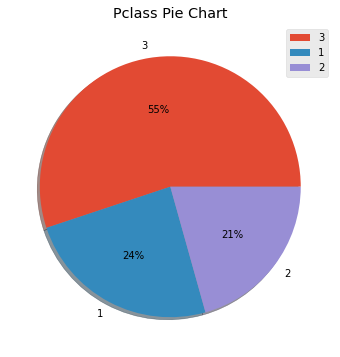

In [6]:
vsl.build_pie_chart(train_data['Pclass'])

### JOINT DISTRIBUTION WITH SURVIVED

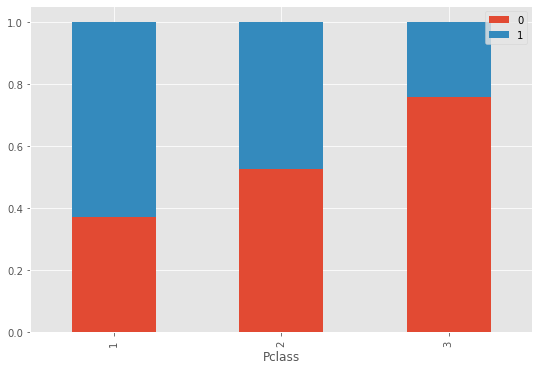

In [7]:
vsl.build_stacked_bars_chart(train_data['Pclass'], train_data['Survived'])

From the above graphic we can see a relation between Survived and Pclass, as we can see, when Pclass decreases survivors proportion increases.

In [12]:
chi_pvalue_pclass = chi2_contingency(pd.crosstab(train_data['Pclass'], train_data['Survived']))[1]
chi_pvalue_pclass 

4.549251711298793e-23

The Chi square test shows that the Characters Pclass and Survived are not independent, so, it could be a feature in the model.

## 1.3 Sex

### MARGINAL DISTRIBUTION

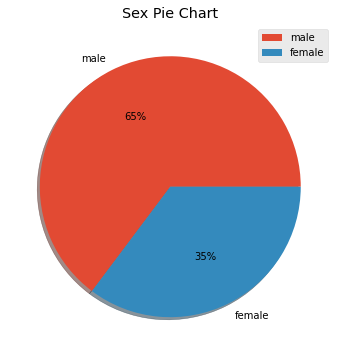

In [8]:
vsl.build_pie_chart(train_data['Sex'])

### JOINT DISTRIBUTION WITH SURVIVED

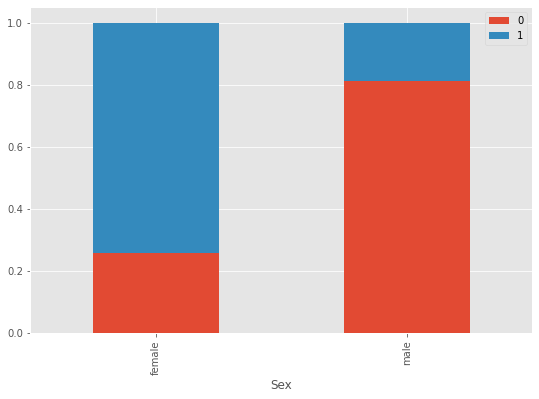

In [9]:
vsl.build_stacked_bars_chart(train_data['Sex'], train_data['Survived'])

We can see that females represent aprroximately 1/3 of the passage, but, they have a significant higher probability to survive than males, so, it could be a feature in the model.

In [42]:
chi_pvalue_pclass = chi2_contingency(pd.crosstab(train_data['Sex'], train_data['Survived']))[1]
chi_pvalue_pclass 

1.1973570627755645e-58

The Chisquare Pvalue shows that the characters Sex and Survived are not independent, so it could be a feature in the model. 

## 1.4 Age

### MARGINAL DISTRIBUTION

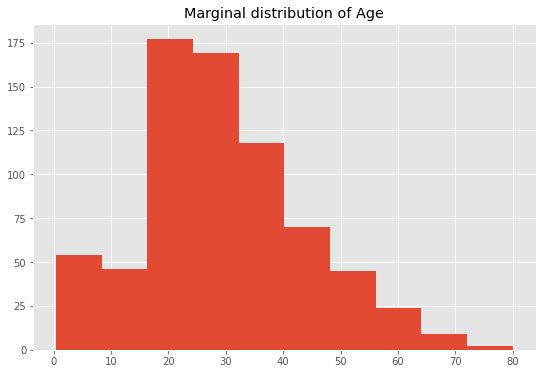

In [10]:
plt.hist(train_data['Age'])
plt.title('Marginal distribution of Age')
plt.show()

From the above histogram we can conclude that a great majority of the passage is between 18 and 30 years approximately. It seems a distribution skewed to the right and it is not any well-known distribution. Specially, The normality assumption it is not justified as we can see in the Kolmogorov-Smirnov pvalue.

In [11]:
kstest(train_data['Age'].dropna(), 'norm')

KstestResult(statistic=0.9650366565902186, pvalue=0.0)

In spite of non normality, we can assume that the distribution is approximately symmetric as we can see in kurtosis and skew coefficients.

In [12]:
print('kurtosis:', kurtosis(train_data['Age'].dropna()), 'skew:', skew(train_data['Age'].dropna()))

kurtosis: 0.16863657224286044 skew: 0.3882898514698657


### JOINT DISTRIBUTION WITH SURVIVED

<AxesSubplot:xlabel='Age', ylabel='Count'>

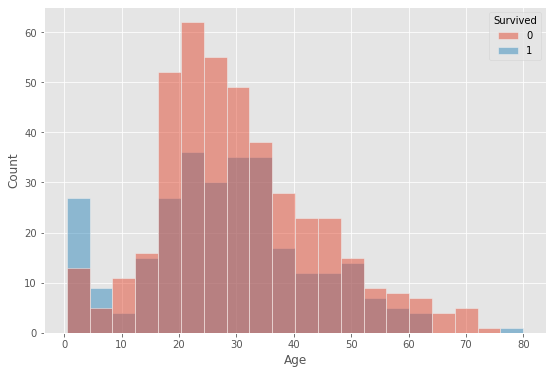

In [13]:
sns.histplot(data=train_data, x='Age', hue='Survived')

We can notice than childs have the highest chance to survive, and in the center of the distribution (young and middle-age persons) have approximately the same probability to survive or not. For the oldest people we can see that, in overall, nobody survived. 

That feature seems useful to predict survivors,so, we will include it in the model, but first, we have to implement a method to fill the null values.

## 1.5 SibSp

### MARGINAL DISTRIBUTION

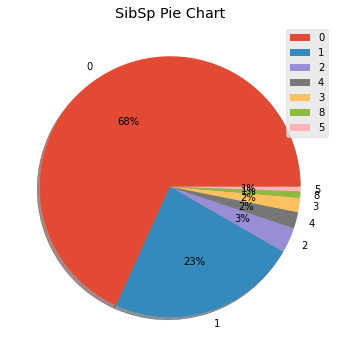

In [14]:
vsl.build_pie_chart(train_data['SibSp'])

### JOINT DISTRIBUTION WITH SURVIVED

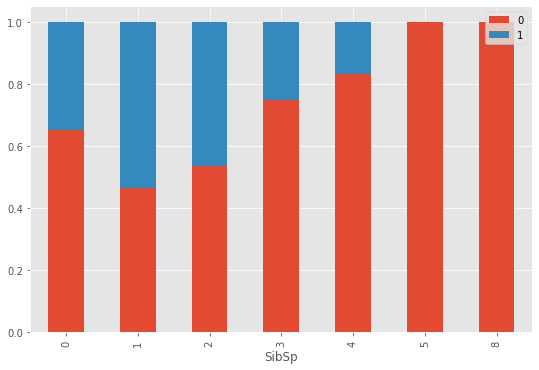

In [15]:
vsl.build_stacked_bars_chart(train_data['SibSp'], train_data['Survived'])

We can see that the probability of survive decreases when SibSp increases (in overall), this feature could be included in the model.

In [43]:
chi_pvalue_pclass = chi2_contingency(pd.crosstab(train_data['SibSp'], train_data['Survived']))[1]
chi_pvalue_pclass 

1.5585810465902147e-06

The chi square test shows that the chracters SibSp and Survived are not independent, so it could be a feature in the model.

## 1.6 Parch

### MARGINAL DISTRIBUTION

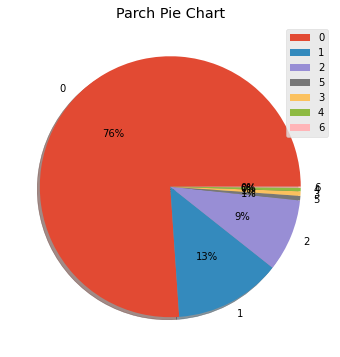

In [16]:
vsl.build_pie_chart(train_data['Parch'])

### JOINT DISTRIBUTION WITH SURVIVED

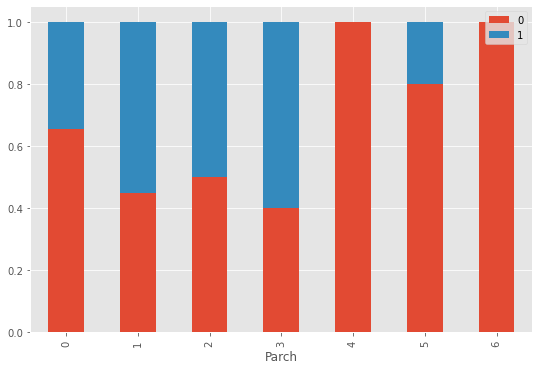

In [17]:
vsl.build_stacked_bars_chart(train_data['Parch'], train_data['Survived'])

From the joint distribution we can see a (slight) relation between the Parch and Survived, where Parch increases the probability of survive decreases.

*Comment*: In overall, that feature has the same relation with survived as SibSp, so, it could be a good idea merge both features in a unique feature to prevent correlation between features in the future model.

In [44]:
chi_pvalue_pclass = chi2_contingency(pd.crosstab(train_data['Parch'], train_data['Survived']))[1]
chi_pvalue_pclass 

9.703526421039997e-05

The chi square test shows that the chracters Parch and Survived are not independent, so, it could be a feature in the model.

## 1.7 Fare

### MARGINAL DISTRIBUTION

<AxesSubplot:xlabel='Fare', ylabel='Count'>

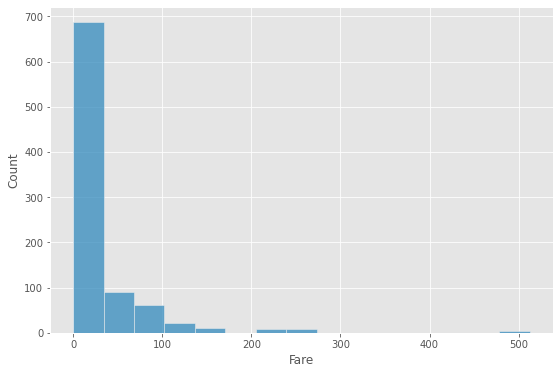

In [18]:
sns.histplot(data=train_data, x='Fare', bins=15)

### JOINT DISTRIBUTION WITH SURVIVED

<AxesSubplot:xlabel='Fare', ylabel='Count'>

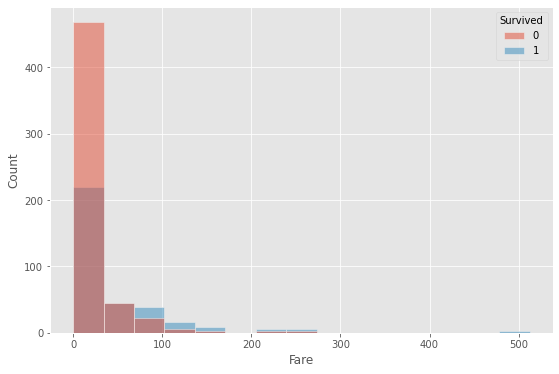

In [19]:
sns.histplot(data=train_data, x='Fare', hue='Survived', bins=15)

We can see that the probability of survive increases when Fare increases, so, it could be a feature in the model, but, probably, its correlated with Pclass, we have to take care if we include both features to prevent high correlations between model features.

## 1.8 Embarked

### MARGINAL DISTRIBUTION

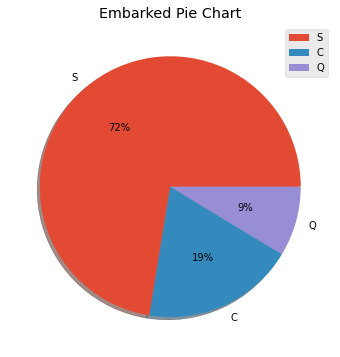

In [20]:
vsl.build_pie_chart(train_data['Embarked'])

### JOINT DISTRIBUTION WITH SURVIVED

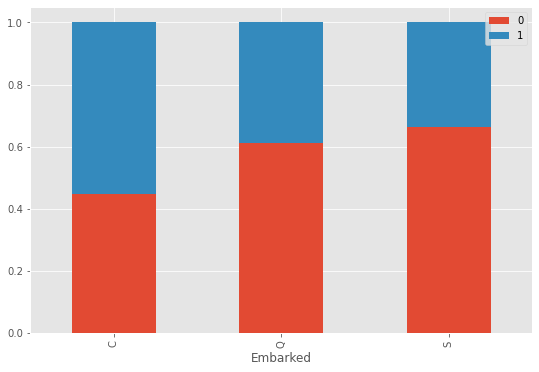

In [21]:
vsl.build_stacked_bars_chart(train_data['Embarked'], train_data['Survived'])

We can see a slight relation between the place where the passenger embarked and the probability of survive, but it does not seem significant. We will test different models including or not this feature and we will se if it is relevant or not.

In [47]:
chi_pvalue_pclass = chi2_contingency(pd.crosstab(train_data['Embarked'], train_data['Survived']))[1]
chi_pvalue_pclass

1.769922284120912e-06

In addition, it has null values as we can see below.

In [22]:
train_data['Embarked'].isnull().sum()

2

Due to the small number of null values we will replace it with the mode.

In [23]:
mode_embarked = train_data['Embarked'].mode()[0]

In [24]:
train_data.loc[train_data['Embarked'].isnull(), 'Embarked'] = mode_embarked
train_data['Embarked'].isnull().sum()  # check if the null values are filled

0

## 1.9 Name

In [25]:
train_data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In a simplistic approach, names do not seem a reason to survive a disaster, but, if we remind that we need to fill Age null values, definetly, the salutations before the surname can be very useful to locate persons in an age band. We will develop these ideas later.

## 1.10 Cabin

It is reasonable to think that cabins distribution could be a reason to survive in order to some natural factors as the distance to the nearest safeboats or the initial hole in the boat, so, we are going to check if this feature has a relation with survived.

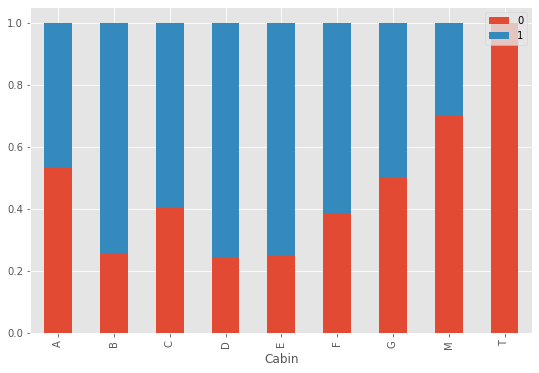

In [26]:
vsl.build_stacked_bars_chart(train_data['Cabin'].fillna('Missing').apply(lambda x: x[:1]),
                             train_data['Survived'].loc[train_data['Cabin'].index])

We can see that the survive probability conditioned by the cabin first letter is different for every Cabin value, Cabins B, D and E have a higher proportion of suvivors than G, C, A. It seems to be a relation and we could include that feature in the model.

Note that we have filled the null values with the Cabin label 'Missing', it could be reasonable, as we can see above, becacause a great part of the passengers who traveled in that Cabin died, so, it is natural that their Cabin is unknown. 

Lets check too the relation between Cabin and some other variables.

In [48]:
chi_pvalue_pclass = chi2_contingency(pd.crosstab(
                            train_data['Cabin'].fillna('Missing').apply(lambda x: x[:1]),
                             train_data['Survived'].loc[train_data['Cabin'].index]))[1]
chi_pvalue_pclass

6.326020042314704e-18

The chi square test shows that the characters Cabin and Survived are not independent so it could be a feature in the model.

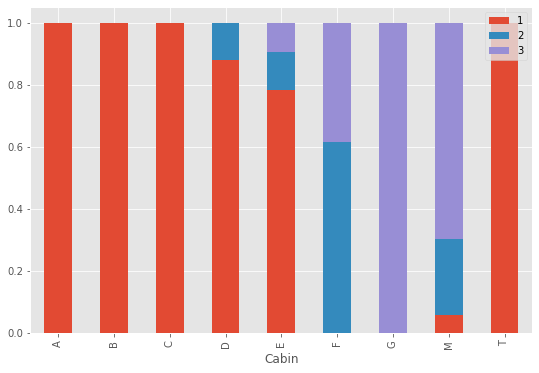

In [27]:
vsl.build_stacked_bars_chart(train_data['Cabin'].fillna('Missing').apply(lambda x: x[:1]),
                             train_data['Pclass'].loc[train_data['Cabin'].index])

We notice that Cabins could be assigned by class, A, B, and C is assigned for the first class passengers, the others have mixed classes. So, we have to take care about correlation between both features.

## Conclusion

We have seen (with the Chi Square Test) that every cathegorical feature seem not independent from Survived, so, we should not discard any feature mentioned above and study their correlations carefully. We will do it in a future notebook, but during this notebook we will assume that every feature has a significance.

# 2. Features enginering <a class="anchor" id="FE"></a>

## 2.1 Name as a way to fill Age null values.

In this section, as mentioned previously, we are going to extract passengers salutations with the goal to extract their titles, in addition, it could be a good stratification feature in order to infer an age band for passengers which would allow us to fill Age null values.

Let's take a look of the names format in the dataset.

In [28]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The format seems to be 'name, salutation. surname' so, the appropiate tool to get the salutations will be  a regex rule runned over every Name to keep the string inmediately before the points.

In [29]:
train_data['Title'] = train_data.Name.str.extract('([A-Za-z]+)\.', expand=False) 
train_data['Title'].value_counts(normalize=True)  # overview of saludations

Mr          0.580247
Miss        0.204265
Mrs         0.140292
Master      0.044893
Dr          0.007856
Rev         0.006734
Col         0.002245
Major       0.002245
Mlle        0.002245
Countess    0.001122
Lady        0.001122
Ms          0.001122
Mme         0.001122
Sir         0.001122
Capt        0.001122
Jonkheer    0.001122
Don         0.001122
Name: Title, dtype: float64

We can see that there common salutations such as Mr o Miss, but, we have find multiple salutations which are rare such as Countess or Jonkheer. Seems reasonable to make groups in order to the most common titles and mke and additional group containin rare titles:

1. Mr and Mrs: man and women who are married
2. Miss: women not married
2. Master: an special title for minors. 
3. Rare: those which are not included above

In [30]:
train_data['Title'] = train_data['Title'].apply(lambda x: 
                          1 if x in ['Mr', 'Mrs'] else 
                          (2 if x == 'Miss' else 
                           (3 if x == 'Master' else 4)))

group_means = []

for age_group in train_data['Title'].unique().tolist():
    
    group_means.append(train_data[train_data['Title'].isin([age_group])]['Age'].mean())
    
means_dict = dict(zip(train_data['Title'].unique().tolist(), group_means)) # dict to use with replace

as we can see our stratification seems reasonable, every group has a different age mean.

In [31]:
pd.DataFrame.from_dict(means_dict, orient='index', columns=['mean']).transpose()

,1,2,3,4
mean,33.121542,21.773973,4.574167,42.384615


Finally we can fill the values.

In [32]:
ages_to_fill = train_data[train_data['Age'].isnull()]['Title'].replace(means_dict)
ages_to_fill = ages_to_fill.apply(int) # transform age into int type
train_data.loc[ages_to_fill.index, 'Age'] = ages_to_fill

train_data['Age'].isnull().sum()  # we can check that there is no null values now

0

Before leave this section it could a good idea check the joint distribution of title and Survived, as we said above, Age is related with Survived, so, it is reasonable that our new feature, Title, has inherited that relation, because salutations are based in the age, experience and knowledge.

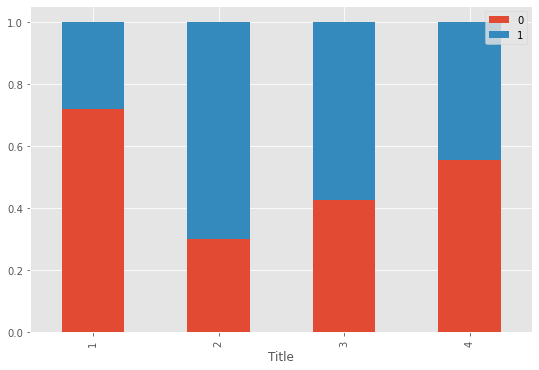

In [33]:
vsl.build_stacked_bars_chart(train_data['Title'], train_data['Survived'])

As expected, the relation is inherited, and probably, it could be a good feature rather than simply Age, we will see in the model selection.

## 2.2 Family features

As we concluded above, SibSp and Parch can duplicate information about a passenger family status in the model, because they showed a similar relation with Survived. It could be a good idea to summarize both features in only one boolean feature that we will call Alone, which values are 1 if the passengers travles alone and 0 if the passenger travels with some family member/s.

In [34]:
train_data['Alone'] = (train_data['SibSp'] + train_data['Parch'] + 1).apply(lambda x: 0 if x!=1 else 1)

As always, now we check the relations with Survived

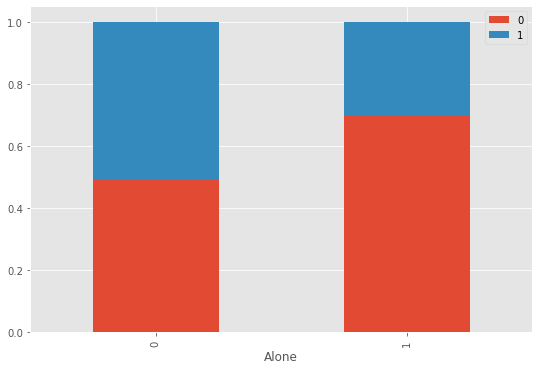

In [35]:
vsl.build_stacked_bars_chart(train_data['Alone'], train_data['Survived'])

And we can see a slight relation between both variables, we will study the feature in the model selection.

# 3. Hipothesis and analysis discussion <a class="anchor" id="MH"></a>

As a conclussion from the above exploratory analysis, it seems clear that we have to solve a supervised classification problem, so, the classical techniques used in this kind of problems are: Logistic Regression, Decission Trees and his variant Random Forest.

At the beginning, we will try to fit the most simple and classical models such as Logistic Regression and Decission Trees. If they do not give us good results (at least 75% of accuracy) we will try to add more complexity in order to increase the accuracy.

It is clear that we are on a competition, but from the science point of view, if we have two models, one simple and other complex, and they bring us similar accuracies for example 0.76 (simple) and 0.8 (complex), there is no reason to choose the complex model, we should try to find the most simple model which is able to explain as better as possible the target feature.

Probably, models builded with a lot of features have a good accuracy but they lose generality in that process, and from my point of view, a great model is that model which can perform as more general as possible, in different scenearies with the minimum number of features.

# 4. Model building <a class="anchor" id="MB"></a>

In this section we are going to prepare the data in order to apply models over a prepared features dataset, we will create all necessary dummy features and copy the original dataset columns in order to prevent undesiderable modifications of the original data.

## 4.1 Features creation

Notice that we are going to create every features that we considered relevant during the exploratory analysis but it does not mean that we will use all of them in the model, as we said, some of them can be correlated.

In [36]:
#sex featrue
Isfemale = pd.get_dummies(train_data['Sex'])['female']

# extra features from Age, not very useful
# Isold = train_data['Old'].copy()  

# SibSp features 
Isalone = train_data['Alone'].copy()
SibSp = train_data['SibSp'].copy()
Parch = train_data['Parch'].copy()

# class features
C1 = pd.get_dummies(train_data['Pclass'])[1]
C2 = pd.get_dummies(train_data['Pclass'])[2]
Pclass = train_data['Pclass']

# numeric features
scaler = StandardScaler()

Age = train_data['Age'].copy()
Age = pd.Series(scaler.fit_transform(np.array(Age).reshape(-1,1))[:, 0])
#Age (bins)
Age_bins = pd.cut(train_data['Age'], bins=10, labels=range(10))


Fare = train_data['Fare'].copy()
Fare = pd.Series(scaler.fit_transform(np.array(Fare).reshape(-1,1))[:, 0])

# Fare bins
Fare_bins = pd.cut(train_data['Fare'], bins=10, labels=range(10))

# embarked features
Isq = pd.get_dummies(train_data['Embarked'])['Q']
Iss = pd.get_dummies(train_data['Embarked'])['S']

# title features
IsMr = train_data['Name'].apply(lambda x: 1 if 'Mr' in x else 0)
IsMrs = train_data['Name'].apply(lambda x: 1 if 'Mrs' in x else 0)
Isminor = pd.get_dummies(train_data['Title'])[3]
Ismiss = pd.get_dummies(train_data['Title'])[2]
Israre = pd.get_dummies(train_data['Title'])[4]

#Cabin features
Cabin = pd.get_dummies(train_data['Cabin'].fillna('Missing').apply(lambda x: x[:1]))
Cabin['M'] = Cabin['M'] + Cabin['T']  # add T Cabin to M
Cabin.drop('T', axis=1, inplace=True)  # remove Cabin T

X = pd.concat([Isfemale, Isalone, C1,
           C2, Age, Fare, Isq, Iss, IsMr, IsMrs,
           Isminor, Ismiss, Israre, SibSp, Parch,
               Pclass, Age_bins, Fare_bins, Cabin], axis=1, ignore_index=True)

feature_names = ['Isfemale', 'Isalone', 'C1',
           'C2', 'Age', 'Fare', 'Isq', 'Iss', 'Ismr', 'Ismrs',
           'Isminor', 'Ismiss', 'Israre', 'SibSp', 'Parch', 'Pclass',
                 'Age_bins', 'Fare_bins', 'CabinA','CabinB',
                 'CabinC', 'CabinD', 'CabinE',	'CabinF', 'CabinG', 'CabinM']

X.columns = feature_names

y = train_data['Survived']

## 4.2 Running basic models

Now we are going to discuss some feature sets in order to run different models and choose the best perfromance.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

MODEL 1: Sex, Age, Fare, Pclass, SibSp, Parch, 

## DECISSION TREES

In [38]:
def plot_cross_validation(scores):
    
    print('\n')
    plt.bar(range(len(scores)), scores)
    plt.xlabel('folds')
    plt.ylabel('score obtained')
    plt.title('Cross validation result')
    plt.hlines(np.mean(scores), xmin=0, xmax=9, linestyles='dashed', colors='black')
    plt.legend(['mean', 'result CV'])
    plt.show()

def run_decission_tree(features):
    
    DT = DecisionTreeClassifier(max_depth=3, random_state=0)
    DT.fit(X_train[features], y_train)

    scores = cross_val_score(DT, X_train, y_train, cv=10)
    print('average score CV:', np.mean(scores))
    print('\naccuracy_training:', DT.score(X_train[features], y_train))
    print('\naccuracy_testing:', DT.score(X_test[features], y_test))


    plot_cross_validation(scores)
    print('\n')
    print(pd.DataFrame(zip(features, DT.feature_importances_),columns=['feature', 'importance']))
    DT.fit(X, y) # returns fitted model and features

    return DT, features

def run_logit(features):
    
    logit = LogisticRegression(max_iter=1000, C=5.0)
    logit.fit(X_train[features], y_train)
    scores = cross_val_score(logit, X_train, y_train, cv=10)

    print('average score CV:', np.mean(scores))
    print('accuracy_training:', logit.score(X_train[features], y_train))
    print('accuracy_test:', logit.score(X_test[features], y_test))
    
    print('\n')
    plot_cross_validation(scores)
    
    LR = Logit(y_train, X_train[features])
    result = LR.fit()
    print('\n\n', result.summary2())
    
    logit.fit(X[features], y) # returns fitted model and features
    
    return logit, features

As an example, we know that gender submission scores more or less a 75%

average score CV: 0.8009216589861751

accuracy_training: 0.7865168539325843

accuracy_testing: 0.7873134328358209




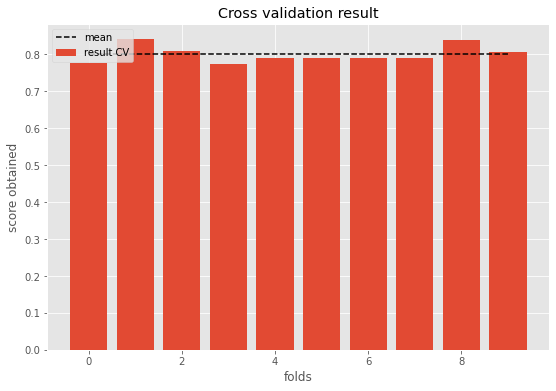



    feature  importance
0  Isfemale         1.0


In [39]:
modelGS_feat = ['Isfemale']
DT, features_GS = run_decission_tree(modelGS_feat)

### Model 1: We will use just the initial features (without any enginered features) to see if they can predict at least more survivors than the gender submission.

Notice that I am not quite sure that Embarked is an useful feature and I will not include it in the first model until the complexity is requiered.

In [40]:
model1_feat = ['Isfemale', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 
               'CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinM']

average score CV: 0.8009216589861751

accuracy_training: 0.8282504012841091

accuracy_testing: 0.8097014925373134




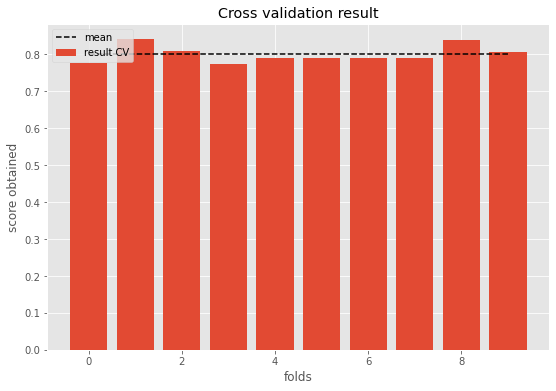



     feature  importance
0   Isfemale    0.654447
1     Pclass    0.138130
2        Age    0.086877
3       Fare    0.056537
4      SibSp    0.000000
5      Parch    0.000000
6     CabinA    0.000000
7     CabinB    0.000000
8     CabinC    0.000000
9     CabinD    0.000000
10    CabinE    0.000000
11    CabinF    0.000000
12    CabinM    0.064008


In [41]:
DT, features_DT = run_decission_tree(model1_feat)

Wee can see that Sex (Isfemale) is the most important feature, in fact, 2/3 of importance is more or less equivalent to the gender submission, so, definetly, our model does not differs too much from the gender submission.

Finally, Cabins features does not seem important in the model with one exception, CabinM, the missing values of Cabin original column,so, we will remove every Cabin feature.

average score CV: 0.8009216589861751

accuracy_training: 0.8378812199036918

accuracy_testing: 0.8246268656716418




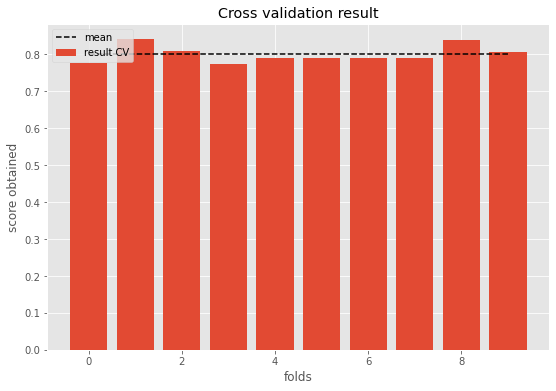



    feature  importance
0  Isfemale    0.608649
1    Pclass    0.174525
2       Age    0.066519
3      Fare    0.052581
4     SibSp    0.097726


In [42]:
model1_feat = ['Isfemale', 'Pclass', 'Age', 'Fare', 'SibSp']
DT, features_DT = run_decission_tree(model1_feat)

### model 2: Focus on add information to Isfemale feature to increase de accuracy of gender submission

average score CV: 0.8009216589861751

accuracy_training: 0.8346709470304976

accuracy_testing: 0.8208955223880597




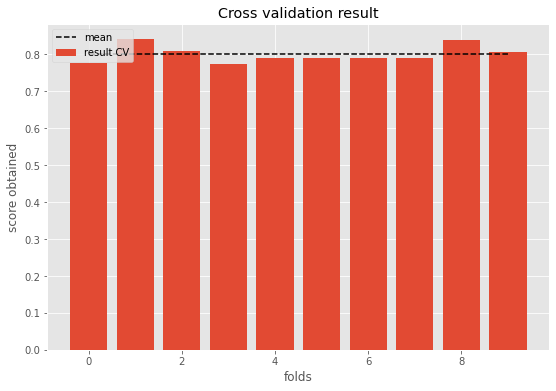



    feature  importance
0  Isfemale    0.691405
1     SibSp    0.190145
2     Parch    0.018881
3   Isminor    0.065811
4       Age    0.033758


In [43]:
model2_feat = ['Isfemale', 'SibSp', 'Parch', 'Isminor', 'Age']
DT, features_DT2 = run_decission_tree(model2_feat)

As we can see the empirical results are very similar to the first model. 

We can conclude that Sex is a central feature in every model, and, in order to improve our predictions, it could be a good idea to explore deeply this feature and families (or person groups) aboard the passage.

## Logistic Regression

Now we fit a Logistic Regression over the whole set of features

average score CV: 0.8235279057859703
accuracy_training: 0.8426966292134831
accuracy_test: 0.832089552238806






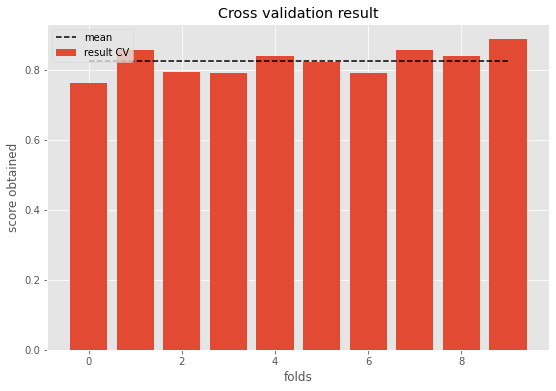

Optimization terminated successfully.
         Current function value: 0.397883
         Iterations 7


                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.404     
Dependent Variable: Survived         AIC:              533.7624  
Date:               2020-11-29 22:33 BIC:              618.0188  
No. Observations:   623              Log-Likelihood:   -247.88   
Df Model:           18               LL-Null:          -416.19   
Df Residuals:       604              LLR p-value:      1.3413e-60
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
CabinM         1.2401    0.8397   1.4768  0.1397  -0.4057   2.8858
CabinB         1.3055    0.9564   1.3650  0.1723  -0.5691  

In [44]:
LR, features_LR = run_logit(set(feature_names)-set(['C1', 'C2',
                                                  'Age_bins', 'Fare_bins',
                                                  'CabinG', 'Isalone', 'Israre']))

We can see that cross validation and scores in training and testing are very similar, so, there is no evidence of overfitting. In addition, in overall, every coefficient is significant (Isq has a high pvalue, as expected, Embarked could not be important to classify survivors).

Finally, standard errors are stable, so there is no reason to think that exists significant multicolineality in the model. It could be a good idea to make an outliers and check if the result improves, it will be done in a future notebook.

# 6. Conclussions <a class="anchor" id="C"></a>

After fitting the models we can conlude that, with the actual knowledge about the data, there is no reason (from the scientific point of view) to include more complexity, because we can obtain relative high rates of accuracy with very simple models (acc $\approx$ 0.79 -> top 10%).

In another notebook, we will try more complex models in order to improve the accuracy for the competition, for example, we can try to use: Random Forest, Perceptron, Extra Tree, SVG... We will see those techniques and others in another notebook.

# 7. Submission <a class="anchor" id="S"></a>

For the submission we will use the scripts, but the process is exactly the same as the above cells.

In [45]:
test = pd.read_csv('../data/raw/test.csv')

fln.fill_age_values(test)
fln.fill_embarked(test)
fln.fill_fare_value(test)

sub_features, _ = bf.build_features(test)

Age null values filled successfully
No null values found
Embarked value filled successfully 
Fare value filled successfully


In [ ]:
submit_result(sub_features, LR, features_LR)